# ImageNet 100-Class Training with ResNet50
## Target: 82%+ Validation Accuracy

This notebook trains ResNet50 on 100 selected ImageNet classes with:
- **~130,000 training images** (~1,300 per class)
- **~5,000 validation images** (~50 per class)
- **Heavy data augmentation** for maximum accuracy
- **Training from scratch** (no checkpoints)

**Hardware Recommendations:**
- MacBook M1/M2/M3: Use MPS backend (automatic)
- NVIDIA GPU: CUDA will be used automatically
- CPU only: Reduce batch_size to 32 and num_workers to 2

## Cell 1: Imports

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Local imports
from model import create_resnet50, get_model_stats
from data_loader_100classes import get_100class_dataloaders
from train import Trainer

print("✓ Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available() if hasattr(torch.backends, 'mps') else False}")

✓ Imports successful!
PyTorch version: 2.8.0
CUDA available: False
MPS available: True


## Cell 2: Device Configuration

In [12]:
# Automatic device selection
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✓ Using CUDA: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
    print("✓ Using Apple Metal Performance Shaders (MPS)")
else:
    device = torch.device('cpu')
    print("⚠️  Using CPU (training will be slow)")

print(f"Device: {device}")

✓ Using Apple Metal Performance Shaders (MPS)
Device: mps


## Cell 3: Training Configuration

**Optimized for 82%+ validation accuracy on 100 classes**

In [ ]:
config = {
    # Data Configuration
    'data_dir': './imagenet_100class_data',
    'num_classes': 100,  # Training on 100 classes only
    'auto_download': True,  # Auto-download if dataset not found
    
    # Training Configuration
    'num_epochs': 90,  # 90 epochs for 82%+ accuracy
    'batch_size': 128,  # Reduce to 64 or 32 if OOM on MacBook
    'num_workers': 4,  # Reduce to 2 on MacBook if needed
    'pin_memory': True,
    
    # Heavy Augmentation (critical for high accuracy)
    'augmentation_strength': 'medium',  # RandomResizedCrop, ColorJitter, RandomErasing
    
    # Learning Rate Configuration
    'find_lr': True,  # Auto-find optimal learning rate
    'initial_lr': 0.05,  # Starting LR (overridden if find_lr=True)
    'max_lr': 0.3,      # Max LR for OneCycleLR (overridden if find_lr=True)
    
    # Regularization
    'weight_decay': 1e-4,  # L2 regularization
    'label_smoothing': 0,  # Label smoothing for better generalization
    'max_grad_norm': 1.0,  # Gradient clipping
    
    # Model Configuration
    'zero_init_residual': True,  # Zero-init residual connections
    
    # Checkpoint Configuration
    'checkpoint_dir': './checkpoints_100class',
    'save_frequency': 5,  # Save every 5 epochs
    'div_factor': 25.0,  # initial_lr = max_lr / div_factor
}

print("="*60)
print("TRAINING CONFIGURATION")
print("="*60)
for key, value in config.items():
    print(f"{key:25s}: {value}")
print("="*60)

TRAINING CONFIGURATION
data_dir                 : ./imagenet_100class_data
num_classes              : 100
auto_download            : True
num_epochs               : 90
batch_size               : 128
num_workers              : 4
pin_memory               : True
augmentation_strength    : medium
find_lr                  : True
initial_lr               : 0.05
max_lr                   : 0.3
weight_decay             : 0.0001
label_smoothing          : 0.1
max_grad_norm            : 1.0
zero_init_residual       : True
checkpoint_dir           : ./checkpoints_100class
save_frequency           : 5
div_factor               : 25.0


## Cell 4: Load 100-Class ImageNet Data

**First run will download ~10-12 GB (2-3 hours)**

**Subsequent runs will load from disk (fast)**

In [14]:
print("\n" + "="*60)
print("LOADING 100-CLASS IMAGENET DATASET")
print("="*60)
print("Expected dataset size:")
print("  Training:   ~130,000 images (~1,300 per class)")
print("  Validation: ~5,000 images (~50 per class)")
print("  Disk space: ~10-12 GB")
print("  Download:   ~2-3 hours (first time only)")
print("="*60 + "\n")

train_loader, val_loader, num_classes, class_names = get_100class_dataloaders(
    data_dir=config['data_dir'],
    batch_size=config['batch_size'],
    num_workers=config['num_workers'],
    auto_download=config['auto_download'],
    augmentation_strength=config['augmentation_strength'],
    pin_memory=config['pin_memory']
)

print(f"\n✓ Data loaded successfully!")
print(f"  Number of classes: {num_classes}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")


LOADING 100-CLASS IMAGENET DATASET
Expected dataset size:
  Training:   ~130,000 images (~1,300 per class)
  Validation: ~5,000 images (~50 per class)
  Disk space: ~10-12 GB
  Download:   ~2-3 hours (first time only)


Loading 100-class ImageNet from imagenet_100class_data...
✓ Data loaded successfully!
  Number of classes: 100
  Training samples: 129,173
  Validation samples: 5,000
  Train batches: 1009
  Val batches: 40
  Augmentation: medium
  Samples per class (train): ~1292
  Samples per class (val): ~50

✓ Data loaded successfully!
  Number of classes: 100
  Training batches: 1009
  Validation batches: 40


## Cell 5: Visualize Sample Images

Verify data loading and augmentation

/Users/prateekgarg/Documents/ERAV4/Session_9/Assignment/Image_net_training_model/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


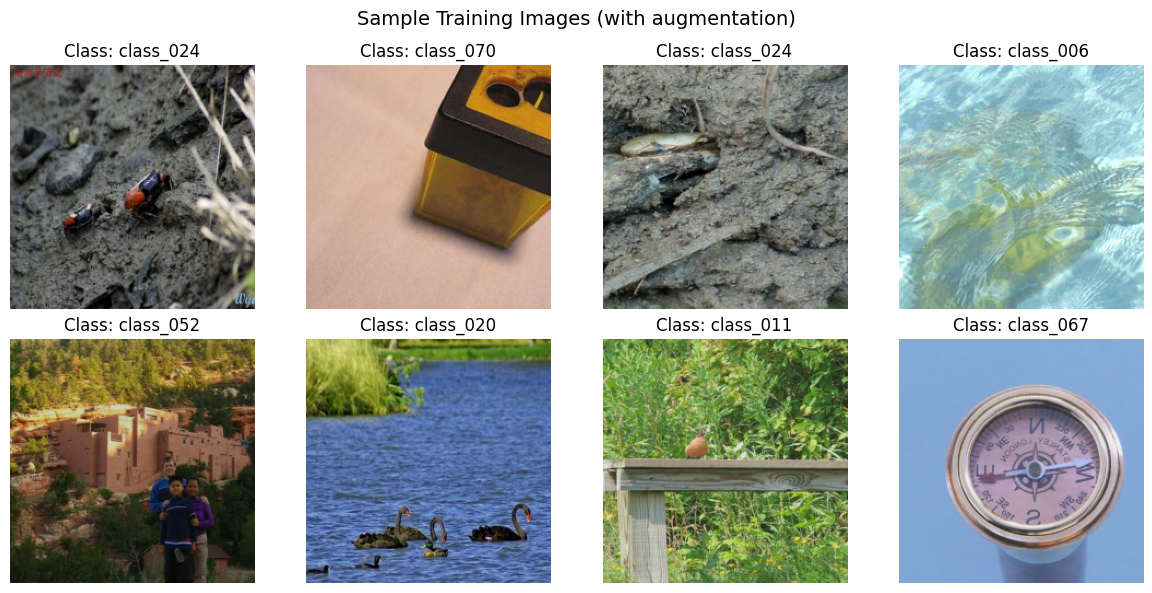

Batch shape: torch.Size([128, 3, 224, 224])
Labels shape: torch.Size([128])
Image value range: [-2.118, 2.640]


In [15]:
from data_normalisation import denormalize_image

# Get a batch of training images
images, labels = next(iter(train_loader))

# Denormalize for visualization
images_denorm = denormalize_image(images)

# Plot first 8 images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(8):
    img = images_denorm[i].permute(1, 2, 0).cpu().numpy()
    axes[i].imshow(img)
    axes[i].set_title(f"Class: {class_names[labels[i]]}")
    axes[i].axis('off')

plt.suptitle('Sample Training Images (with augmentation)', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Image value range: [{images.min():.3f}, {images.max():.3f}]")

## Cell 6: Create ResNet50 Model

In [16]:
print("\nCreating ResNet50 model for 100 classes...")

model = create_resnet50(
    num_classes=config['num_classes'],
    zero_init_residual=config['zero_init_residual']
)

model = model.to(device)

# Get model statistics
stats = get_model_stats(model)

print("\n" + "="*60)
print("MODEL STATISTICS")
print("="*60)
print(f"Total parameters:      {stats['total_parameters']:,}")
print(f"Trainable parameters:  {stats['trainable_parameters']:,}")
print(f"Model size:            {stats['model_size_mb']:.2f} MB")
print("="*60)

print(f"\n✓ Model created and moved to {device}")


Creating ResNet50 model for 100 classes...

MODEL STATISTICS
Total parameters:      23,712,932
Trainable parameters:  23,712,932
Model size:            90.46 MB

✓ Model created and moved to mps


## Cell 7: Learning Rate Finder (Optional but Recommended)

**Automatically finds optimal learning rate range**

2025-10-20 16:16:59,411 - INFO - Trainer initialized on device: mps
2025-10-20 16:16:59,412 - INFO - Mixed precision (AMP) enabled: False



LEARNING RATE FINDER
Running LR range test to find optimal learning rates...
This will take 5-10 minutes.


Learning Rate Finder
Testing range: 1.00e-08 to 1.00e+01
Number of iterations: 4000



Finding LR: 100%|██████████| 4000/4000 [1:32:23<00:00,  1.39s/it, lr=9.95e+00, loss=4.5588]



✓ LR finding complete!
  Tested 4000 learning rates
  Loss range: [3.7557, 4.6572]

✓ Model and optimizer restored to original state



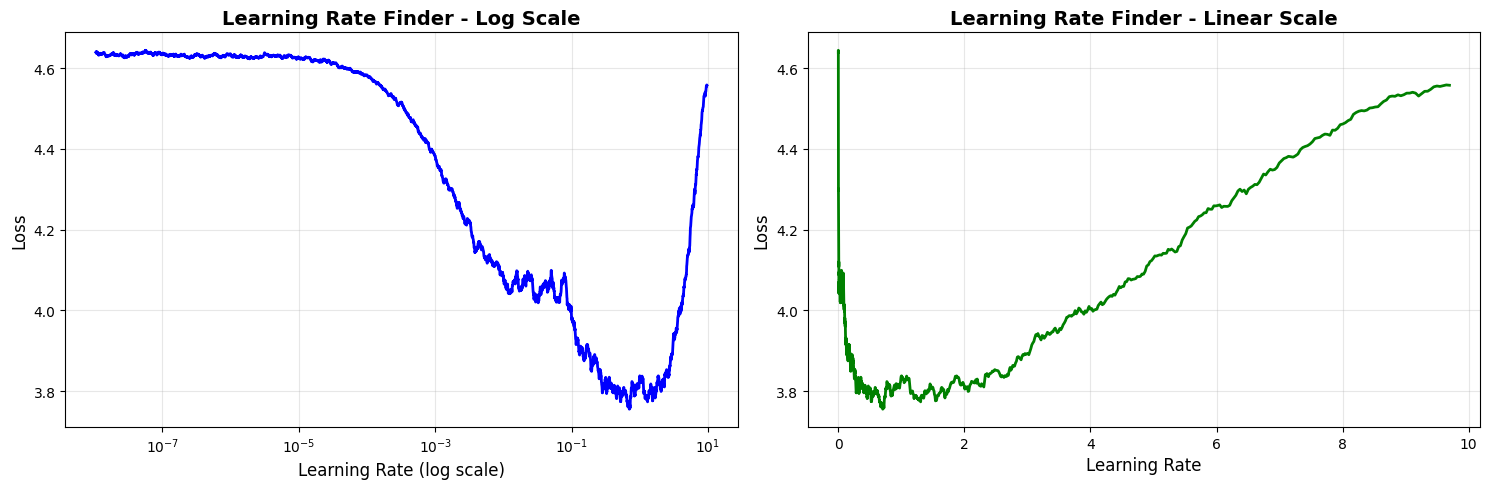

📌 Updating initial_lr to 7.05e-02 (max_lr / div_factor)

SUGGESTED LEARNING RATES:
  Initial LR: 0.070469

Reloading model with fresh weights...
✓ Model reloaded


In [19]:
if config['find_lr']:
    print("\n" + "="*60)
    print("LEARNING RATE FINDER")
    print("="*60)
    print("Running LR range test to find optimal learning rates...")
    print("This will take 5-10 minutes.\n")
    
    from lr_finder import LRFinder
    
    # Create temporary trainer for LR finding
    temp_trainer = Trainer(
        model=model,
        device=device,
        #checkpoint_dir=config['checkpoint_dir']
    )
    
    lr_finder = LRFinder(
        model=model,
        optimizer=optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=config['weight_decay']),
        criterion=nn.CrossEntropyLoss(label_smoothing=config['label_smoothing']),
        device=device
    )
    lrs, losses, initial_lr, max_lr= lr_finder.find(
        train_loader,
        init_lr=1e-8,
        end_lr=10,
        num_iter= 4000
    )
    
    # Find suggested learning rates
    #suggested_lr, suggested_max_lr = lr_finder.suggest_lr(lrs, losses)
    
    # Plot results
    lr_finder.plot(lrs, losses)
    
    # Update config with suggested values
    # print(f"📌 Updating max_lr from {config['max_lr']:.2e} to {suggested_lr:.2e}")
    config['max_lr'] = max_lr
    # # Set initial_lr proportionally
    config['initial_lr'] = initial_lr
    print(f"📌 Updating initial_lr to {config['initial_lr']:.2e} (max_lr / div_factor)")
    
    print(f"\n" + "="*60)
    print(f"SUGGESTED LEARNING RATES:")
    print(f"  Initial LR: {config['initial_lr']:.6f}")
    # print(f"  Max LR:     {suggested_lr:.6f}")
    print("="*60)
    
    # Reload model to reset weights after LR finder
    print("\nReloading model with fresh weights...")
    model = create_resnet50(
        num_classes=config['num_classes'],
        zero_init_residual=config['zero_init_residual']
    )
    model = model.to(device)
    print("✓ Model reloaded")
else:
    print("\n⚠️  Skipping LR finder (using manual LR values)")
    print(f"  Initial LR: {config['initial_lr']}")
    print(f"  Max LR:     {config['max_lr']}")

## Cell 8: Create Optimizer, Scheduler, and Trainer

In [20]:
print(f"  Initial LR: {config['initial_lr']}")
print(f"  Max LR:     {config['max_lr']}")
# from lr_finder import LRFinder
# lr_finder.plot(lrs, losses)
# # Update config with suggested values
# # print(f"📌 Updating max_lr from {config['max_lr']:.2e} to {suggested_lr:.2e}")
# config['max_lr'] = suggested_lr
#     # Set initial_lr proportionally
# config['initial_lr'] = suggested_lr / 25.0
# print(f"📌 Updating initial_lr to {config['initial_lr']:.2e} (max_lr / div_factor)")
    
# print(f"\n" + "="*60)
# print(f"SUGGESTED LEARNING RATES:")
# print(f"  Initial LR: {config['initial_lr']:.6f}")
# print(f"  Max LR:     {suggested_lr:.6f}")
# print("="*60)
    
#     # Reload model to reset weights after LR finder
# print("\nReloading model with fresh weights...")
# model = create_resnet50(
#     num_classes=config['num_classes'],
#     zero_init_residual=config['zero_init_residual']
# )
# model = model.to(device)
# print("✓ Model reloaded")


  Initial LR: 0.07046930689670702
  Max LR:     0.7046930689670702


In [21]:
print("\nCreating optimizer and scheduler...")

# Optimizer: SGD with momentum
optimizer = optim.SGD(
    model.parameters(),
    lr=config['initial_lr'],
    #lr=7e-2,
    momentum=0.9,
    weight_decay=config['weight_decay'],
    nesterov=True
)

# Scheduler: OneCycleLR for optimal convergence
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=config['max_lr'],
    #max_lr=1.75,
    epochs=config['num_epochs'],
    steps_per_epoch=len(train_loader),
    pct_start=0.3,  # 30% warmup
    anneal_strategy='cos',
    div_factor=25.0,  # initial_lr = max_lr / 25
    final_div_factor=1e4  # final_lr = initial_lr / 10000
)

# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

# Create trainer
trainer = Trainer(
    model=model,
    device=device,
    checkpoint_dir=config['checkpoint_dir'],
    max_grad_norm=config['max_grad_norm']
)

print("✓ Optimizer, scheduler, and trainer created")
print(f"  Optimizer: SGD with momentum (Nesterov)")
print(f"  Scheduler: OneCycleLR")
print(f"  Initial LR: {config['initial_lr']:.6f}")
print(f"  Max LR:     {config['max_lr']:.6f}")
print(f"  Loss: CrossEntropyLoss (label_smoothing={config['label_smoothing']})")

2025-10-20 17:56:23,524 - INFO - Trainer initialized on device: mps
2025-10-20 17:56:23,525 - INFO - Mixed precision (AMP) enabled: False



Creating optimizer and scheduler...
✓ Optimizer, scheduler, and trainer created
  Optimizer: SGD with momentum (Nesterov)
  Scheduler: OneCycleLR
  Initial LR: 0.070469
  Max LR:     0.704693
  Loss: CrossEntropyLoss (label_smoothing=0.1)


## Cell 9: Start Training

**Target: 82%+ validation accuracy in 90 epochs**

**Expected timeline:**
- Epochs 1-30: Warmup and rapid learning (30-50% val acc)
- Epochs 31-60: Steady improvement (50-70% val acc)
- Epochs 61-90: Fine-tuning (70-82%+ val acc)

**MacBook M1/M2/M3:**
- ~3-5 minutes per epoch
- Total time: ~4-7 hours for 90 epochs

**NVIDIA GPU:**
- ~1-2 minutes per epoch
- Total time: ~1.5-3 hours for 90 epochs

In [ ]:
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)
print(f"Target: {config['num_epochs']} epochs")
print(f"Goal: 82%+ validation accuracy")
print(f"Augmentation: {config['augmentation_strength']}")
print("="*60 + "\n")

# Train the model
history = trainer.train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=config['num_epochs'],
    #device=device,
    #save_frequency=config['save_frequency']
)

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)

2025-10-20 17:56:33,948 - INFO - Starting training from epoch 0 to 90
2025-10-20 17:56:33,948 - INFO - 
Epoch 0/89, LR: 2.82e-02



STARTING TRAINING
Target: 90 epochs
Goal: 82%+ validation accuracy
Augmentation: medium



Epoch 0 [Val]: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s, loss=3.48, top1_acc=22.5, top5_acc=51.5]
2025-10-20 18:20:34,026 - INFO - Train Loss: 3.8303, Train Acc: 14.78%
2025-10-20 18:20:34,027 - INFO - Val Loss: 3.4840, Val Acc: 22.50%, Top-5 Acc: 51.52%
2025-10-20 18:20:34,028 - INFO - Epoch time: 1440.08s
2025-10-20 18:20:34,730 - INFO - Saved best model with accuracy: 22.50%
2025-10-20 18:20:34,738 - INFO - 
Epoch 1/89, LR: 3.05e-02
Epoch 1 [Val]: 100%|██████████| 40/40 [00:15<00:00,  2.54it/s, loss=3.24, top1_acc=28.9, top5_acc=60.1]
2025-10-20 18:44:38,786 - INFO - Train Loss: 3.3670, Train Acc: 25.22%
2025-10-20 18:44:38,787 - INFO - Val Loss: 3.2399, Val Acc: 28.94%, Top-5 Acc: 60.14%
2025-10-20 18:44:38,787 - INFO - Epoch time: 1444.05s
2025-10-20 18:44:39,439 - INFO - Saved best model with accuracy: 28.94%
2025-10-20 18:44:39,444 - INFO - 
Epoch 2/89, LR: 3.73e-02
Epoch 2 [Val]: 100%|██████████| 40/40 [00:16<00:00,  2.50it/s, loss=2.88, top1_acc=38.1, top5_acc=69]  
2025

## Cell 10: Plot Training History

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training and Validation Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss over Epochs')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Training and Validation Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Val Accuracy', linewidth=2)
axes[0, 1].axhline(y=82, color='r', linestyle='--', label='82% Target', alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Accuracy over Epochs')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Learning Rate Schedule
axes[1, 0].plot(history['learning_rate'], linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Top-5 Accuracy
if 'train_top5_acc' in history and 'val_top5_acc' in history:
    axes[1, 1].plot(history['train_top5_acc'], label='Train Top-5', linewidth=2)
    axes[1, 1].plot(history['val_top5_acc'], label='Val Top-5', linewidth=2)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Top-5 Accuracy (%)')
    axes[1, 1].set_title('Top-5 Accuracy over Epochs')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
else:
    # Show validation accuracy zoomed in
    axes[1, 1].plot(history['val_acc'], label='Val Accuracy', linewidth=2, color='green')
    axes[1, 1].axhline(y=82, color='r', linestyle='--', label='82% Target', alpha=0.7)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Validation Accuracy (%)')
    axes[1, 1].set_title('Validation Accuracy (Zoomed)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_100classes.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final statistics
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Best Validation Accuracy: {max(history['val_acc']):.2f}%")
print(f"Final Training Accuracy:  {history['train_acc'][-1]:.2f}%")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
print(f"Final Training Loss:      {history['train_loss'][-1]:.4f}")
print(f"Final Validation Loss:    {history['val_loss'][-1]:.4f}")

if max(history['val_acc']) >= 82:
    print("\n🎉 TARGET ACHIEVED: 82%+ validation accuracy!")
else:
    print(f"\n⚠️  Target not reached yet ({max(history['val_acc']):.2f}% vs 82% target)")
    print("Consider:")
    print("  - Training for more epochs")
    print("  - Adjusting learning rate")
    print("  - Using transfer learning from pretrained weights")

print("="*60)

## Cell 11: Evaluate Best Model

In [ ]:
print("\nLoading best checkpoint for final evaluation...")

# Load best model
best_checkpoint_path = Path(config['checkpoint_dir']) / 'best_model.pth'
if best_checkpoint_path.exists():
    checkpoint = torch.load(best_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Loaded best model from epoch {checkpoint['epoch']}")
    print(f"  Best validation accuracy: {checkpoint['best_acc']:.2f}%")
else:
    print("⚠️  Best checkpoint not found, using current model")

# Evaluate on validation set
print("\nRunning final evaluation on validation set...")
model.eval()

correct = 0
total = 0
top5_correct = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Top-1 accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Top-5 accuracy
        _, top5_pred = outputs.topk(5, 1, largest=True, sorted=True)
        top5_correct += top5_pred.eq(labels.view(-1, 1).expand_as(top5_pred)).sum().item()

top1_acc = 100. * correct / total
top5_acc = 100. * top5_correct / total

print("\n" + "="*60)
print("FINAL VALIDATION RESULTS")
print("="*60)
print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")
print(f"Total samples evaluated: {total:,}")
print("="*60)

if top1_acc >= 82:
    print("\n🎉 SUCCESS! Ready to scale to 1000 classes on AWS!")
else:
    print(f"\n⚠️  Top-1 accuracy is {top1_acc:.2f}% (target: 82%+)")

## Cell 12: Save Final Model for AWS Deployment

In [ ]:
# Save model for deployment
deployment_dir = Path('./deployment')
deployment_dir.mkdir(exist_ok=True)

# Save complete model
torch.save({
    'model_state_dict': model.state_dict(),
    'num_classes': config['num_classes'],
    'final_val_acc': top1_acc,
    'final_top5_acc': top5_acc,
    'config': config,
}, deployment_dir / 'resnet50_100class_final.pth')

print("\n✓ Model saved for deployment:")
print(f"  Location: {deployment_dir / 'resnet50_100class_final.pth'}")
print(f"  Validation accuracy: {top1_acc:.2f}%")
print(f"\nReady to scale to 1000 classes on AWS!")

## Next Steps

### If validation accuracy >= 82%:
1. ✅ **100-class training successful!**
2. Scale to full 1000 classes on AWS:
   - Use `data_loader_full.py` instead of `data_loader_100classes.py`
   - Update `num_classes: 1000` in config
   - Consider transfer learning from this 100-class model
   - Train for 90-120 epochs
   - Expected AWS time: ~8-12 hours on p3.2xlarge

### If validation accuracy < 82%:
1. Train for more epochs (up to 120)
2. Try transfer learning from ImageNet pretrained weights
3. Experiment with different learning rates
4. Consider using MixUp or CutMix augmentation
5. Check if dataset downloaded correctly